In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sys; sys.path.insert(0,'/home/micah/Documents/ca_analysis/')
import fileread as fr; import wave_ops as wo;import predefined as pd
from scipy.spatial import distance_matrix

#### create a list of colors, to be used later for cluster plotting

In [2]:
colors = {}
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'lime'
colors[7] = 'navy'
colors[8] = 'pink'
colors[9] = 'khaki'
colors[10] = 'peru'
colors[11] = 'aqua'
colors[12] = 'darkorchid'
colors[13] = 'rosybrown'
colors[14] = 'lightgrey'
colors[15] = 'wheat'
colors[16] = 'gold'
colors[17] = 'aquamarine'
colors[18] = 'springgreen'
colors[19] = 'deeppink'
colors[20] = 'crimson'
colors[-1] = 'k'

#### read in the runs 

In [3]:
runs=[run for run in os.listdir('/home/micah/Documents/Run_60/')       if run.endswith('.bin') and run[4:-6]!='186']
runs.sort()
print(runs)
path='/home/micah/Documents/ca_analysis/cur_data/'
proc_data=fr.gen_output(path+'Run_60-all.dat')[0]

bdch=11#35
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]


mn,mx=0,1460
# proc_data=pd.precuts(proc_data,energy=mn).view(np.recarray)
t=(proc_data.board==bd)*(proc_data.channel==ch)*(proc_data.energy<mx)
proc_data=proc_data[t]

['Run_60_0.bin', 'Run_60_1.bin', 'Run_60_2.bin', 'Run_60_3.bin', 'Run_60_4.bin', 'Run_60_5.bin', 'Run_60_6.bin', 'Run_60_7.bin', 'Run_60_8.bin']


#### read 1000 waves per run, starting at entry 1000 since the first 1000 may contain junk

In [4]:
wfs=[]
path='/home/micah/Documents//Run_60/'

for run in runs:
    numwaves=int((os.stat(path+run).st_size-8)/(7033))
    numwaves=1000
    data=fr.raw(path+run,length=3500,numwaves=numwaves,row=1000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data,pretrigger=600)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    data=data[t]
    tot=len(proc_data)
    for i,stamp in enumerate(proc_data.timestamp):
        if divmod(i,100)[1]==0:
            print('\r'+30*' ',end='')
            print('\r'+'{:0d}% of '.format(int(100*i/tot))+run,end='')
        l=np.nonzero(data.timestamp==stamp)[0]
        if l.shape[0]>0:
            wfs.append(data[l[0]])

wfs=np.asarray(wfs).view(np.recarray)

99% of Run_60_8.bin           

#### store the waveform data in an array

In [5]:
X=wfs.wave[0:len(wfs)].copy().astype('f4')
x_norm = np.zeros_like(X)

#### Example waveform of a clear particle hit. 1 ADC ~= 0.15 keV. Each waveform consists of 3500 time bins. There are 1875 waveforms in our current data matrix

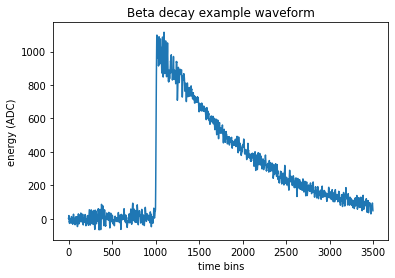

In [6]:
plt.plot(X[204])
plt.xlabel("time bins")
plt.ylabel("energy (ADC)")
plt.title("Beta decay example waveform")
wav_fig = plt.gcf()

#### Normalization function. This shrinks every waveform to be between -1 and 1, so that the electron energy dependence is removed

In [7]:
def normBatch(x):
    for i in range(len(x)):
        x_norm[i] = x[i] - np.amin(x[i])
        x_norm[i] = x_norm[i]*2./np.amax(x[i])
        x_norm[i] = x_norm[i] - 1

In [8]:
normBatch(X)

### Run a singular value decomposition on the data set. This is the first step in orthogonalizing and dimensionality reducing the data, so that it can be efficiently and effectively clustered. Our data matrix is factored into three matrices: U, S, and Vh.

#### For now, focus on the s values that are returned from SVD. These are the singular values of our data set. Numpy is smart and returns our S matrix in order from largest to smallest (and likewise, U and Vh will match this descending order). The square of a singular value tells us the *explained variance* by the axis corresponding to that singular value (remember, the goal is to view our original data set from an orthogonal and dimensionality reduced basis).

In [9]:
u, s, vh = np.linalg.svd(x_norm, full_matrices=False)

In [10]:
scree_order = np.arange(1,len(s)+1)

#### Now make a scree plot of the singular values. This plots the singular values vs. their order (from largest to smallest). This plot will give us some insight into how many dimensions to reduce our data down to. The "elbow" of the scree plot should be close to a good number of dimensions.

(0, 20)

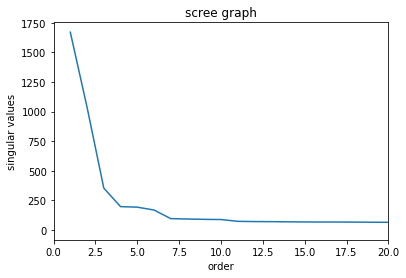

In [11]:
plt.plot(scree_order, s)
plt.title("scree graph")
plt.ylabel("singular values")
plt.xlabel("order")
plt.xlim(0,20)

#### For this data, the elbow looks to be somewhere between 2 and 5

In [12]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]

In [13]:
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance

#### Since the square of the singular value gives us the variance explained by that component, we can now make a plot of the total variance explained by the first *p* principal components (a principal component is a dimension of the orthogonalized data)

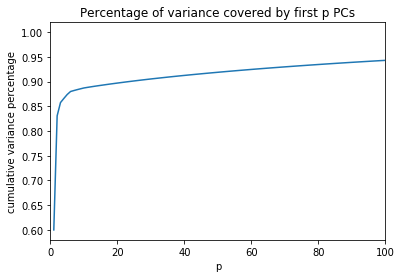

In [14]:
plt.plot(scree_order, pvc)
plt.title('Percentage of variance covered by first p PCs')
plt.xlabel('p')
plt.ylabel('cumulative variance percentage')
plt.xlim(0,100)
percent_var_fig = plt.gcf()

### 83% of the data variance is explained by the first 2 PCs, and then there are drastically diminishing returns by adding more PCs. So, we will try cutting the data down to 2 PCs.

#### Make the cut down to 2 PCs by multiplying our data set by the first 2 columns of the transpose of Vh

In [15]:
v = np.transpose(vh)
delete = np.arange(2, len(s))
v = np.delete(v, delete, axis=1)
reduced_norm_data = x_norm@v

### Now we can visualize the data on a 2D plot, with each axis corresponding to a principal component. Each data point represents a waveform

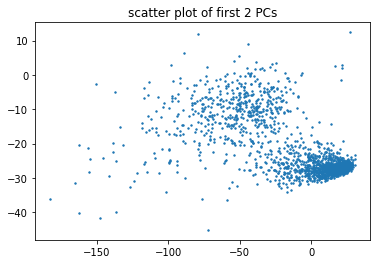

In [16]:
x = reduced_norm_data[:,0] 
y = reduced_norm_data[:,1]
plt.scatter(x,y, s= 2)
plt.title("scatter plot of first 2 PCs")
scatter_fig = plt.gcf()

In [17]:
norm_dist = distance_matrix(reduced_norm_data, reduced_norm_data)

In [18]:
count = 0
temp = np.triu(norm_dist,1)
distances = np.asarray(temp).reshape(-1)
distances = np.sort(distances)
distances = np.flip(distances)

In [19]:
l = len(norm_dist)
nonzeros = int((l*l - l)/2)
order = np.arange(nonzeros)

In [20]:
distances = distances[0:nonzeros]

### The DBSCAN clustering method requires that we provide an epsilon value. This value is the distance that the algorithm will search for the next point. If it finds a point within that epsilon, it will be considered part of the cluster. Points that aren't close enough to any other points are marked as noise.

#### The following plot helps us determine a range of epsilon values to try, since we can see a distribution of distances between each pair of data points

#### From the histogram we can see that the most common distance between points is somewhere from 2 to 6. So we will first try epsilon values in this range

(0, 30)

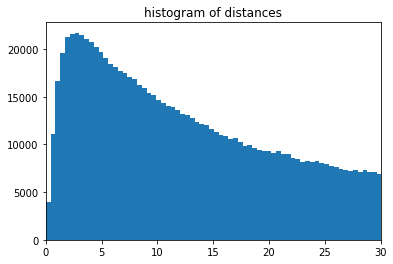

In [22]:
plt.title("histogram of distances")
fig11 = plt.hist(distances, 500)
plt.xlim(0,30)

#### After tuning the hyperparameters (epsilon and min_samples), I found eps = 3 and min_samples = 5 to give good clustering results

In [23]:
db = DBSCAN(eps = 3, min_samples = 5).fit(reduced_norm_data[:,])
labels = db.labels_
cvec = [colors[label] for label in labels] 

#### Now we can visualize what the clusters look like in our 2 dimensional space

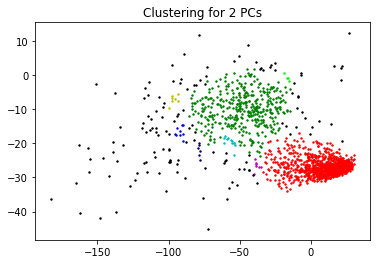

In [24]:
x = reduced_norm_data[:,0]
y = reduced_norm_data[:,1]
fig, ax = plt.subplots()
for i in range(len(x)):
    plt.scatter(x[i],y[i], c = cvec[i], s=2)
plt.title('Clustering for 2 PCs')
two_pc_clust_fig = plt.gcf()

In [25]:
count = 0
for i in range(len(labels)):
    if labels[i] == -1:
        count += 1
print("number of unclustered data points: " + str(count))
print("percentage of data not clustered: " + str(round(100*count/len(labels),2)))
print("number of clusters: " + str(np.max(labels+1)))

number of unclustered data points: 136
percentage of data not clustered: 7.25
number of clusters: 8


### And finally, plot the original waveforms from each cluster, so we can get a physical understanding of what types of waveforms are actually in the clusters.

num points in cluster: 1313
percentage of data in cluster: 70.02666666666667


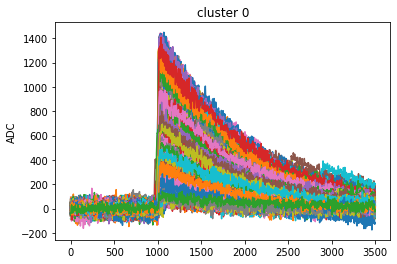

In [26]:
count = 0
for i in range(len(labels)):
    if labels[i] == 0:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 0")
plt.ylabel("ADC")
clust0rawfig = plt.gcf()

num points in cluster: 381
percentage of data in cluster: 20.32


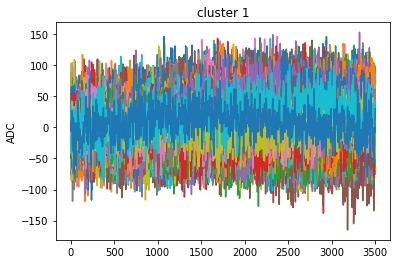

In [27]:
count = 0
for i in range(len(labels)):
    if labels[i] == 1:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 1")
plt.ylabel("ADC")
clust1rawfig = plt.gcf()

num points in cluster: 9
percentage of data in cluster: 0.48


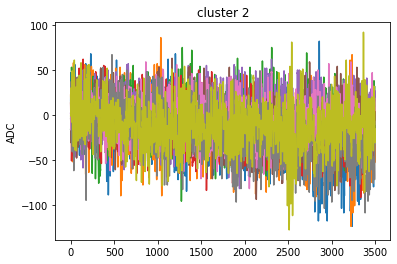

In [28]:
count = 0
for i in range(len(labels)):
    if labels[i] == 2:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 2")
plt.ylabel("ADC")
clust2rawfig = plt.gcf()

num points in cluster: 12
percentage of data in cluster: 0.64


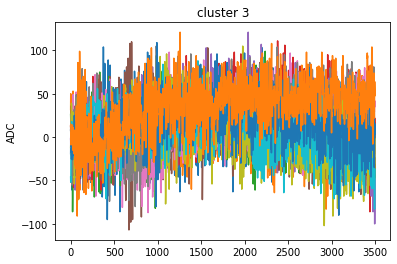

In [29]:
count = 0
for i in range(len(labels)):
    if labels[i] == 3:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 3")
plt.ylabel("ADC")
clust3rawfig = plt.gcf()

num points in cluster: 7
percentage of data in cluster: 0.37333333333333335


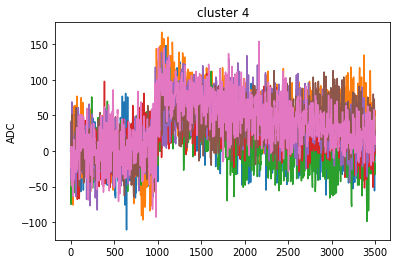

In [30]:
count = 0
for i in range(len(labels)):
    if labels[i] == 4:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 4")
plt.ylabel("ADC")
clust4rawfig = plt.gcf()

num points in cluster: 7
percentage of data in cluster: 0.37333333333333335


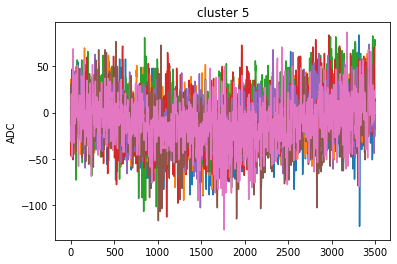

In [31]:
count = 0
for i in range(len(labels)):
    if labels[i] == 5:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 5")
plt.ylabel("ADC")
clust5rawfig = plt.gcf()

num points in cluster: 4
percentage of data in cluster: 0.21333333333333335


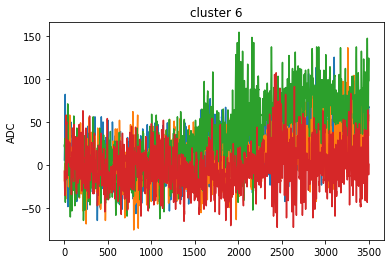

In [32]:
count = 0
for i in range(len(labels)):
    if labels[i] == 6:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 6")
plt.ylabel("ADC")
clust6rawfig = plt.gcf()

num points in cluster: 6
percentage of data in cluster: 0.32


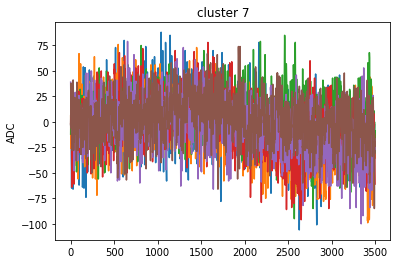

In [33]:
count = 0
for i in range(len(labels)):
    if labels[i] == 7:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("cluster 7")
plt.ylabel("ADC")
clust7rawfig = plt.gcf()

num points in cluster: 136
percentage of data in cluster: 7.253333333333333


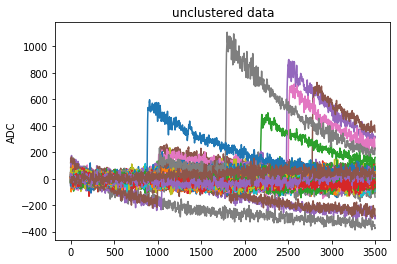

In [34]:
count = 0
for i in range(len(labels)):
    if labels[i] == -1:
        plt.plot(X[i])
        count +=1
print("num points in cluster: " + str(count))
print("percentage of data in cluster: " + str(100*count/len(labels)))
plt.title("unclustered data")
plt.ylabel("ADC")
clustnoiserawfig = plt.gcf()